In [2]:
!kaggle competitions download -c playground-series-s5e3
!unzip playground-series-s5e3

100%|███████████████████████████████████████| 59.0k/59.0k [00:00<00:00, 285kB/s]
100%|███████████████████████████████████████| 59.0k/59.0k [00:00<00:00, 283kB/s]
Archive:  playground-series-s5e3.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [3]:
!rm -rf playground-series-s5e3.zip

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Competition

Based on ROC, illustrates the performance of a Binary Classifier.

From the statement, we know that this must be able to guess the probability. The first things that comes to my mind are:

- KNN
- Trees
- Random Forest
- SVMs
- Logistic Regression
- XGBoost

## Data Analysis

In [2]:
df = pd.read_csv("train.csv")

In [7]:
df.head()

,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
0,0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,1
1,1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,1
2,2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1,1
3,3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6,1
4,4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8,0


In [18]:
df.shape

(2190, 13)

In [10]:
df.dtypes

id                 int64
day                int64
pressure         float64
maxtemp          float64
temparature      float64
mintemp          float64
dewpoint         float64
humidity         float64
cloud            float64
sunshine         float64
winddirection    float64
windspeed        float64
rainfall           int64
dtype: object

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2190 entries, 0 to 2189
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             2190 non-null   int64  
 1   day            2190 non-null   int64  
 2   pressure       2190 non-null   float64
 3   maxtemp        2190 non-null   float64
 4   temparature    2190 non-null   float64
 5   mintemp        2190 non-null   float64
 6   dewpoint       2190 non-null   float64
 7   humidity       2190 non-null   float64
 8   cloud          2190 non-null   float64
 9   sunshine       2190 non-null   float64
 10  winddirection  2190 non-null   float64
 11  windspeed      2190 non-null   float64
 12  rainfall       2190 non-null   int64  
dtypes: float64(10), int64(3)
memory usage: 222.6 KB


In [19]:
df.describe()

,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
count,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000
mean,1094.500000,179.948402,1013.602146,26.365799,23.953059,22.170091,20.454566,82.036530,75.721918,3.744429,104.863151,21.804703,0.753425
std,632.342866,105.203592,5.655366,5.654330,5.222410,5.059120,5.288406,7.800654,18.026498,3.626327,80.002416,9.898659,0.431116
min,0.000000,1.000000,999.000000,10.400000,7.400000,4.000000,-0.300000,39.000000,2.000000,0.000000,10.000000,4.400000,0.000000
25%,547.250000,89.000000,1008.600000,21.300000,19.300000,17.700000,16.800000,77.000000,69.000000,0.400000,40.000000,14.125000,1.000000
50%,1094.500000,178.500000,1013.000000,27.800000,25.500000,23.850000,22.150000,82.000000,83.000000,2.400000,70.000000,20.500000,1.000000
75%,1641.750000,270.000000,1017.775000,31.200000,28.400000,26.400000,25.000000,88.000000,88.000000,6.800000,200.000000,27.900000,1.000000
max,2189.000000,365.000000,1034.600000,36.000000,31.500000,29.800000,26.700000,98.000000,100.000000,12.100000,300.000000,59.500000,1.000000


In [14]:
df.duplicated().sum()

np.int64(0)

In [17]:
df.isnull().sum()

id               0
day              0
pressure         0
maxtemp          0
temparature      0
mintemp          0
dewpoint         0
humidity         0
cloud            0
sunshine         0
winddirection    0
windspeed        0
rainfall         0
dtype: int64

In [26]:
df.nunique()

id               2190
day               365
pressure          236
maxtemp           219
temparature       198
mintemp           199
dewpoint          218
humidity           49
cloud              78
sunshine          120
winddirection      35
windspeed         223
rainfall            2
dtype: int64

- **Rainfall**: although is a binary 0-1, we can see `mean` is not near 0.5. Then we have to take into account this for our model
- **Reescaling is necessary**, as this is pure numerical value data.
- `winddirection, humidity, cloud` have kinda unique values. This might led to categorical variables

In [3]:
target_variable = "rainfall"
numerical_variables = list(filter(lambda e: e != target_variable, df.columns))

### Numerical Analysis

In [23]:
# Function to create and display a row of plots for a single variable
def create_variable_plots(df, variable):
    sns.set_style('whitegrid')
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # Box plot
    sns.boxplot(x=df[variable], ax=axes[0])
    axes[0].set_xlabel(variable)
    axes[0].set_title(f"Box Plot for {variable}")

    # Histogram
    sns.histplot(df[variable], kde=True, bins=30, ax=axes[1])
    axes[1].set_xlabel(variable)
    axes[1].set_ylabel("Frequency")
    axes[1].set_title(f"Histogram for {variable}")

    # Adjust spacing between subplots
    plt.tight_layout()
    plt.show()

def create_variable_pie_plot(df, variable):
    sns.set_style('whitegrid')
    counts = df[variable].value_counts()
    
    fig, ax = plt.subplots(figsize=(10, 4))
    
    ax.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=90, 
           colors=sns.color_palette("pastel"), wedgeprops={'edgecolor': 'black'})
    
    plt.title(f"Pie chart of {variable}")
    plt.tight_layout()
    plt.show()

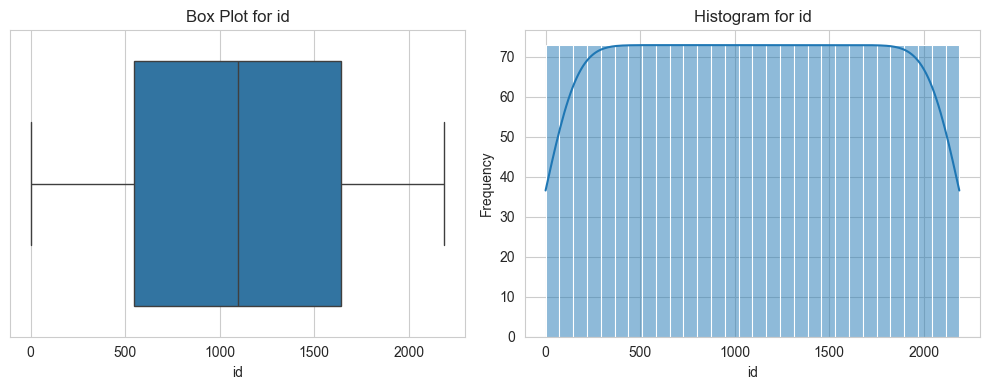

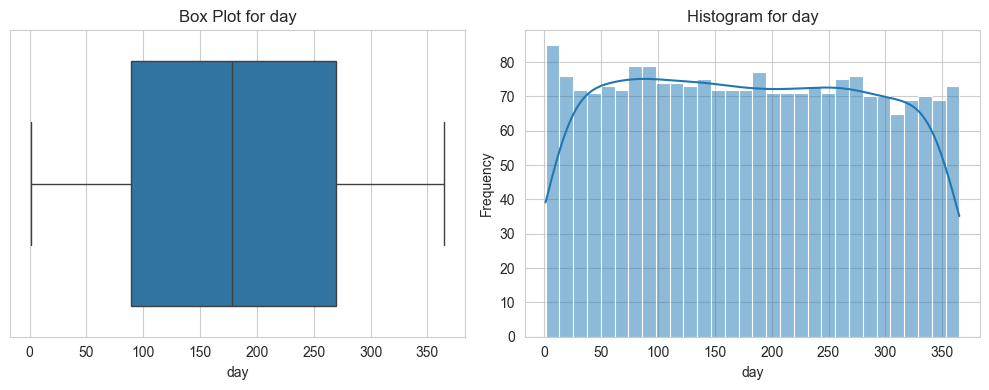

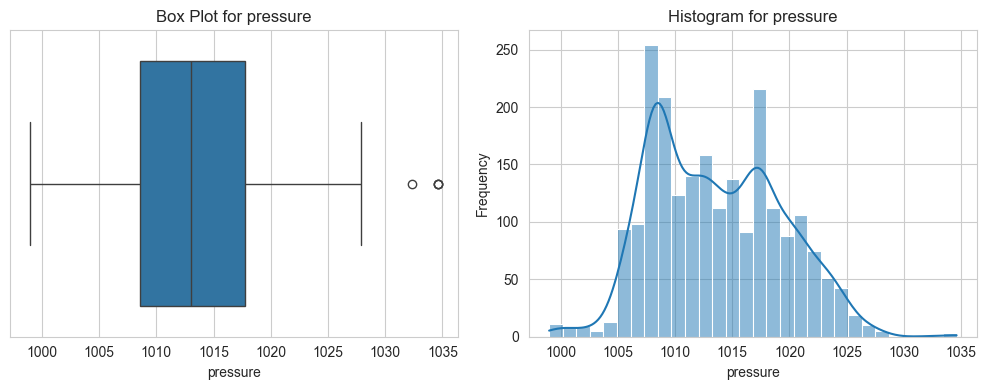

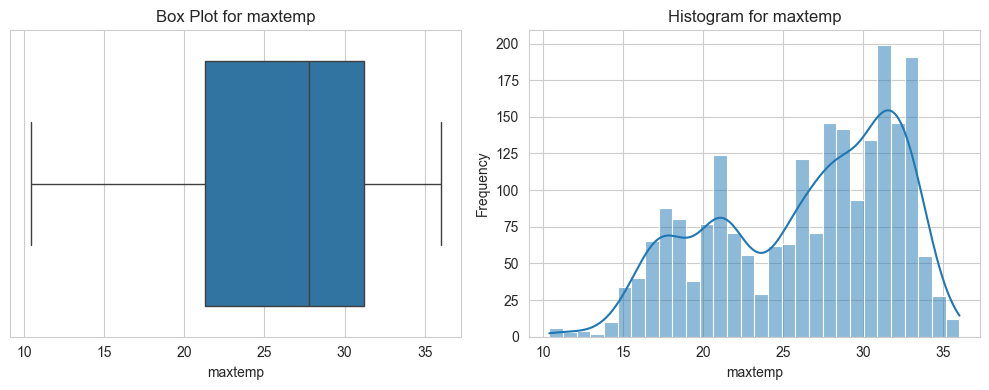

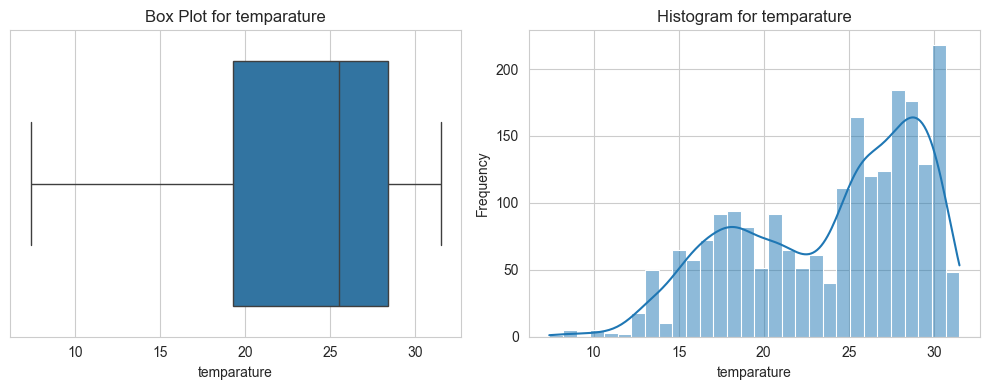

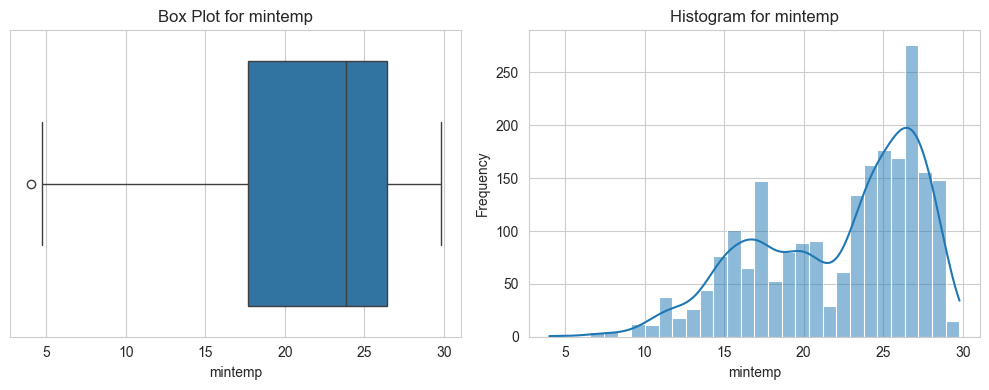

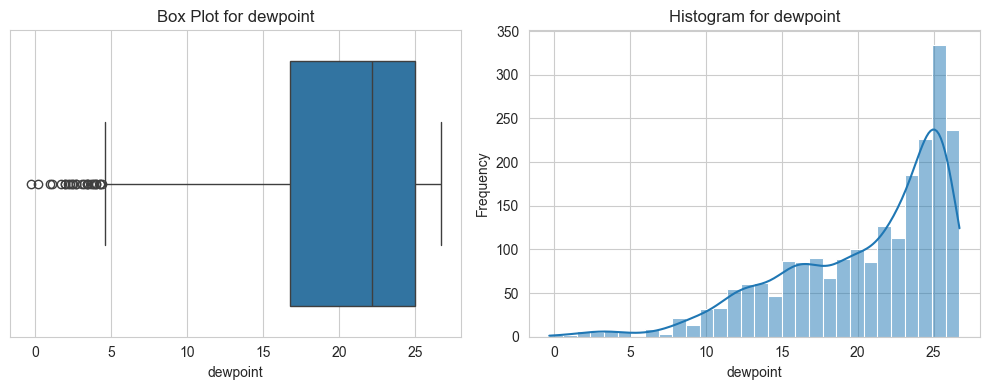

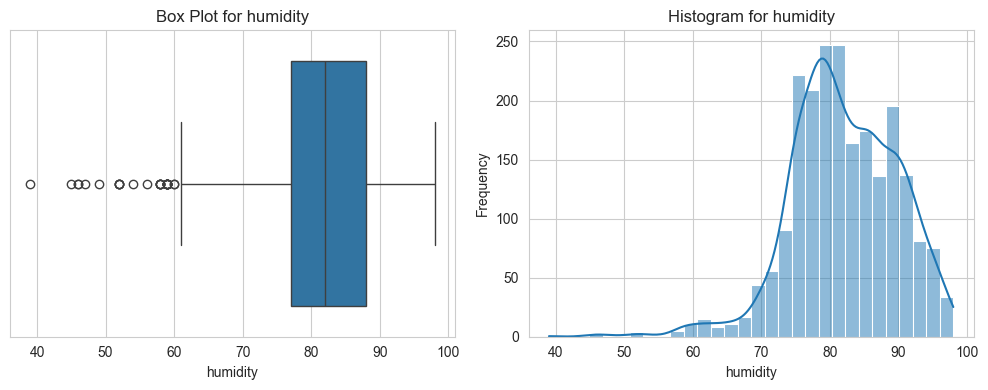

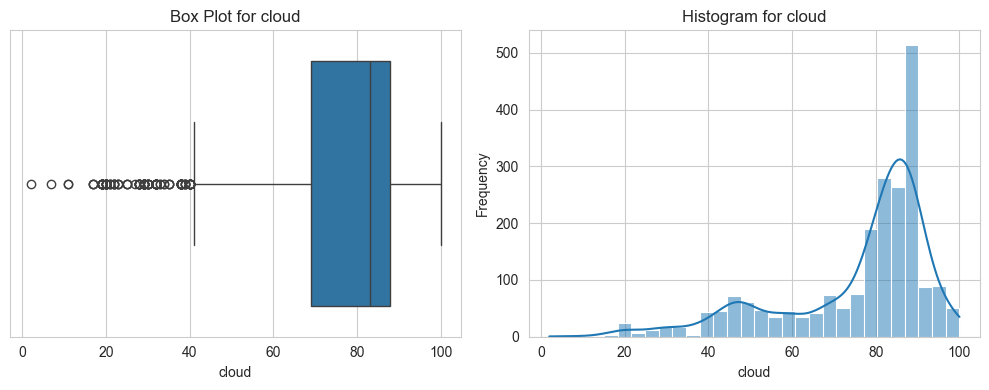

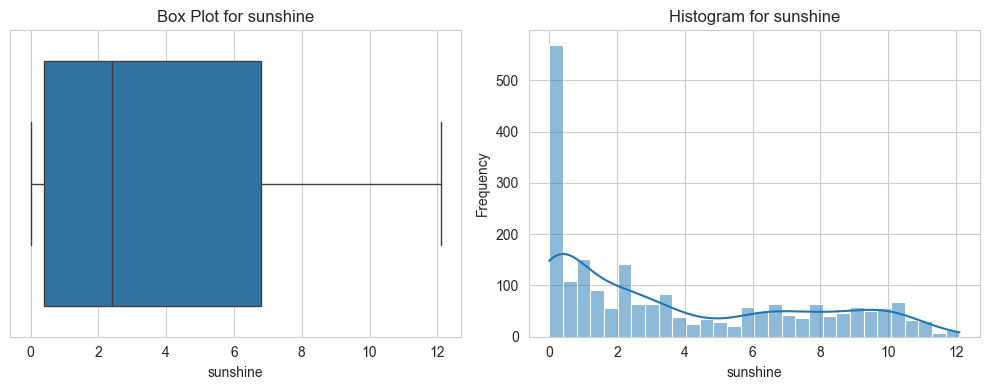

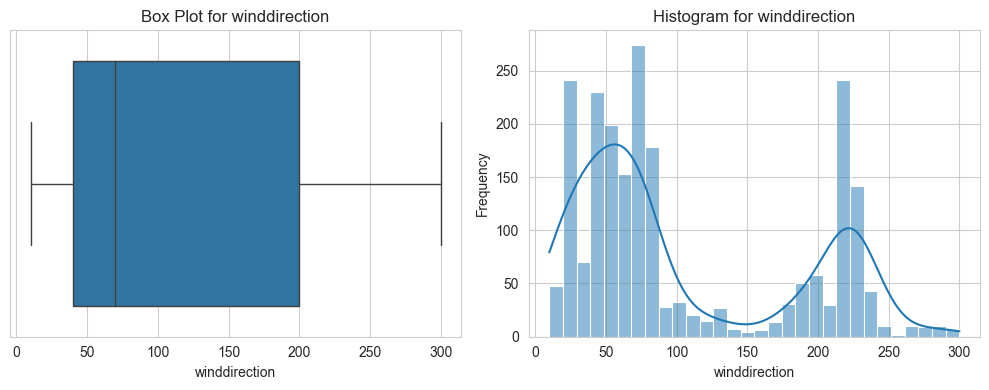

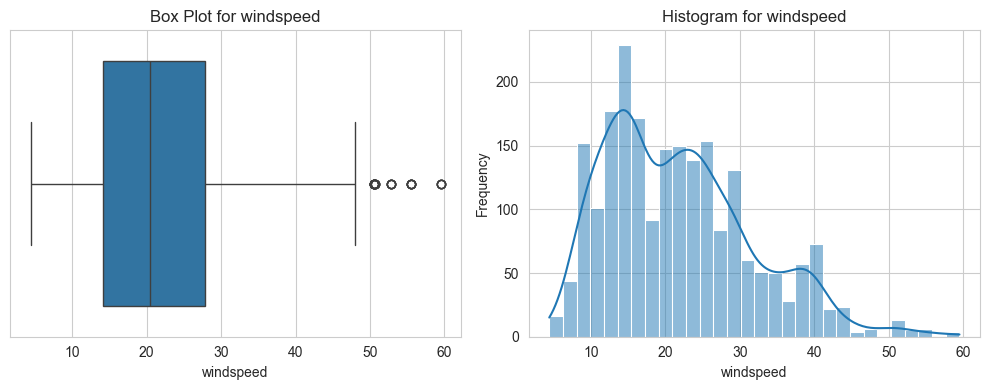

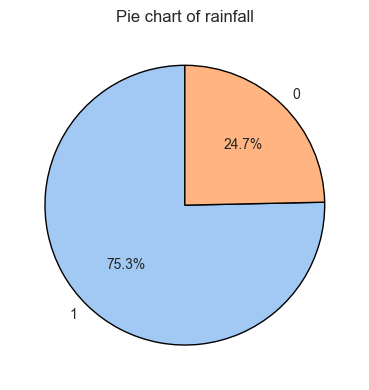

In [24]:
for num_var in numerical_variables:
    create_variable_plots(df, num_var)

create_variable_pie_plot(df, target_variable)

Outliers are considered when the value is 1.5 bigger than the IQR (Q3 - Q1). We can see that: `pressure`, `mintemp` (just 1 outlier), `dewpoint`, `humidity`, `cloud` and `windspeed` have several outliers.

A more extensive analysis from each variable:

`pressure`: follows *almost* a Normal Distribution at around 1013 (from the boxplot) -> need to smooth values 

`maxtemp`: left skewed two peaks. Seasons(? -> binning (agrupar) into temperature ranges to capture seasonality.

`temperature`: left skewed two peaks. Seasons(? -> need to do a relation with max_temp and min_temp

`min_temp`: left sweked two peaks (much bigger the right one) -> as there are some outliers, we can try to smooth data

`dewpoint`: left sweked. Lots of outliers -> log transformation for reducing outliers

`humidity`: outliers. left skewed (most data >= 75%) -> what happens with low humidity?

`cloud`: outliers. left skewed (most data >= 70%) -> correlation with humidity

`sunshine`: highly right skewed. Near 0 -> see negative correlation with cloud and humidity

`winddirection`: bimodal distribution. 50º and 200º. -> hot encoding for capturing possible patterns

`windspeed`: right skewed. Some outliers -> log transformation


Seems that `rainfall` is unbalanced, which will probably affect to the model performance.

- Since the data is skewed toward rainy days, models may struggle to correctly predict non-rainy days.
- We might need resampling techniques (e.g., SMOTE, undersampling) or adjusted class weights to improve balance.
